# Moving Square Video Prediction

This is the third toy example from Jason Brownlee's [Long Short Term Memory Networks with Python](https://machinelearningmastery.com/lstms-with-python/). It illustrates using a CNN LSTM, ie, an LSTM with input from CNN. Per section 8.2 of the book:

> The moving square video prediction problem is contrived to demonstrate the CNN LSTM. The
problem involves the generation of a sequence of frames. In each image a line is drawn from left to right or right to left. Each frame shows the extension of the line by one pixel. The task is for the model to classify whether the line moved left or right in the sequence of frames. Technically, the problem is a sequence classification problem framed with a many-to-one prediction model.

In [1]:
from __future__ import division, print_function
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
%matplotlib inline

In [2]:
DATA_DIR = "../../data"
MODEL_FILE = os.path.join(DATA_DIR, "torch-08-moving-square-{:d}.model")

TRAINING_SIZE = 5000
VALIDATION_SIZE = 100
TEST_SIZE = 500

SEQUENCE_LENGTH = 50
FRAME_SIZE = 50

BATCH_SIZE = 32

NUM_EPOCHS = 5
LEARNING_RATE = 1e-3

## Prepare Data

Our data is going to be batches of sequences of images. Each image will need to be in channel-first format, since Pytorch only supports that format. So our output data will be in the (batch_size, sequence_length, num_channels, height, width) format.

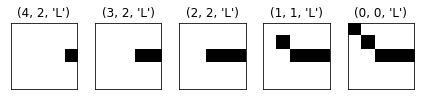

In [3]:
def next_frame(frame, x, y, move_right, upd_int):
    frame_size = frame.shape[0]
    if x is None and y is None:
        x = 0 if (move_right == 1) else (frame_size - 1)
        y = np.random.randint(0, frame_size, 1)[0]
    else:
        if y == 0:
            y = np.random.randint(y, y + 1, 1)[0]
        elif y == frame_size - 1:
            y = np.random.randint(y - 1, y, 1)[0]
        else:
            y = np.random.randint(y - 1, y + 1, 1)[0]
        if move_right:
            x = x + 1
        else:
            x = x - 1
    new_frame = frame.copy()
    new_frame[y, x] = upd_int
    return new_frame, x, y

row, col = None, None
frame = np.ones((5, 5))
move_right = 1 if np.random.random() < 0.5 else 0
for i in range(5):
    frame, col, row = next_frame(frame, col, row, move_right, 0)
    plt.subplot(1, 5, (i+1))
    plt.xticks([])
    plt.yticks([])
    plt.title((col, row, "R" if (move_right==1) else "L"))
    plt.imshow(frame, cmap="gray")
plt.tight_layout()
plt.show()

In [4]:
def generate_data(frame_size, sequence_length, num_samples):
    assert(frame_size == sequence_length)
    xs, ys = [], []
    for bid in range(num_samples):
        frame_seq = []
        row, col = None, None
        frame = np.ones((frame_size, frame_size))
        move_right = 1 if np.random.random() < 0.5 else 0
        for sid in range(sequence_length):
            frm, col, row = next_frame(frame, col, row, move_right, 0)
            frm = frm.reshape((1, frame_size, frame_size))
            frame_seq.append(frm)
        xs.append(np.array(frame_seq))
        ys.append(move_right)
    return np.array(xs), np.array(ys)

X, y = generate_data(FRAME_SIZE, SEQUENCE_LENGTH, 10)
print(X.shape, y.shape)

(10, 50, 1, 50, 50) (10,)


In [5]:
Xtrain, ytrain = generate_data(FRAME_SIZE, SEQUENCE_LENGTH, TRAINING_SIZE)
Xval, yval = generate_data(FRAME_SIZE, SEQUENCE_LENGTH, VALIDATION_SIZE)
Xtest, ytest = generate_data(FRAME_SIZE, SEQUENCE_LENGTH, TEST_SIZE)
print(Xtrain.shape, ytrain.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape)

(5000, 50, 1, 50, 50) (5000,) (100, 50, 1, 50, 50) (100,) (500, 50, 1, 50, 50) (500,)


## Define Network

We want to build a CNN-LSTM network. Each image in the sequence will be fed to a CNN which will learn to produce a feature vector for the image. The sequence of vectors will be fed into an LSTM and the LSTM will learn to generate a context vector that will be then fed into a FCN that will predict if the square is moving left or right.

<img src="08-network-design.png"/>

In [6]:
class CNN(nn.Module):
    
    def __init__(self, input_height, input_width, input_channels, 
                 output_channels, 
                 conv_kernel_size, conv_stride, conv_padding,
                 pool_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, output_channels, 
                               kernel_size=conv_kernel_size, 
                               stride=conv_stride, 
                               padding=conv_padding)
        self.relu1 = nn.ReLU()
        self.output_height = input_height // pool_size
        self.output_width = input_width // pool_size
        self.output_channels = output_channels
        self.pool_size = pool_size
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = F.max_pool2d(x, self.pool_size)
        x = x.view(x.size(0), self.output_channels * self.output_height * self.output_width)
        return x

cnn = CNN(FRAME_SIZE, FRAME_SIZE, 1, 2, 2, 1, 1, 2)
print(cnn)

# size debugging
print("--- size debugging ---")
inp = Variable(torch.randn(BATCH_SIZE, 1, FRAME_SIZE, FRAME_SIZE))
out = cnn(inp)
print(out.size())

CNN (
  (conv1): Conv2d(1, 2, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU ()
)
--- size debugging ---
torch.Size([32, 1250])


In [7]:
class CNNLSTM(nn.Module):
    
    def __init__(self, image_size, input_channels, output_channels, 
                 conv_kernel_size, conv_stride, conv_padding, pool_size, 
                 seq_length, hidden_size, num_layers, output_size):
        super(CNNLSTM, self).__init__()
        # capture variables
        self.num_layers = num_layers
        self.seq_length = seq_length
        self.image_size = image_size
        self.output_channels = output_channels
        self.hidden_size = hidden_size
        self.lstm_input_size = output_channels * (image_size // pool_size) ** 2
        # define network layers
        self.cnn = CNN(image_size, image_size, input_channels, output_channels, 
                       conv_kernel_size, conv_stride, conv_padding, pool_size)
        self.lstm = nn.LSTM(self.lstm_input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        if torch.cuda.is_available():
            h0 = (Variable(torch.randn(self.num_layers, x.size(0), self.hidden_size).cuda()),
                  Variable(torch.randn(self.num_layers, x.size(0), self.hidden_size).cuda()))
        else:
            h0 = (Variable(torch.randn(self.num_layers, x.size(0), self.hidden_size)),
                  Variable(torch.randn(self.num_layers, x.size(0), self.hidden_size)))
        
        cnn_out = []
        for i in range(self.seq_length):
            cnn_out.append(self.cnn(x[:, i, :, :, :]))
        x = torch.cat(cnn_out, dim=1).view(-1, self.seq_length, self.lstm_input_size)
        x, h0 = self.lstm(x, h0)
        x = self.fc(x[:, -1, :])
        x = self.softmax(x)
        return x        

model = CNNLSTM(FRAME_SIZE, 1, 2, 2, 1, 1, 2, SEQUENCE_LENGTH, 50, 1, 2)
if torch.cuda.is_available():
    model.cuda()
print(model)

# size debugging
print("--- size debugging ---")
inp = Variable(torch.randn(BATCH_SIZE, SEQUENCE_LENGTH, 1, FRAME_SIZE, FRAME_SIZE))
out = model(inp)
print(out.size())

CNNLSTM (
  (cnn): CNN (
    (conv1): Conv2d(1, 2, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU ()
  )
  (lstm): LSTM(1250, 50, batch_first=True)
  (fc): Linear (50 -> 2)
  (softmax): Softmax ()
)
--- size debugging ---
torch.Size([32, 2])


In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Train Network

Training on GPU is probably preferable for this example, takes a long time on CPU. During some runs, the training and validation accuracies get stuck, possibly because of bad initializations, the fix appears to be to just retry the training until it results in good training and validation accuracies and use the resulting model.

In [9]:
def compute_accuracy(pred_var, true_var):
    if torch.cuda.is_available():
        ypred = pred_var.cpu().data.numpy()
        ytrue = true_var.cpu().data.numpy()
    else:
        ypred = pred_var.data.numpy()
        ytrue = true_var.data.numpy()
    return accuracy_score(ypred, ytrue)
    
history = []
for epoch in range(NUM_EPOCHS):
    num_batches = Xtrain.shape[0] // BATCH_SIZE
    
    shuffled_indices = np.random.permutation(np.arange(Xtrain.shape[0]))
    train_loss, train_acc = 0., 0.
    for bid in range(num_batches):
        Xbatch_data = Xtrain[shuffled_indices[bid * BATCH_SIZE : (bid+1) * BATCH_SIZE]]
        ybatch_data = ytrain[shuffled_indices[bid * BATCH_SIZE : (bid+1) * BATCH_SIZE]]
        Xbatch = Variable(torch.from_numpy(Xbatch_data).float())
        ybatch = Variable(torch.from_numpy(ybatch_data).long())
        if torch.cuda.is_available():
            Xbatch = Xbatch.cuda()
            ybatch = ybatch.cuda()
            
        # initialize gradients
        optimizer.zero_grad()
        
        # forward
        Ybatch_ = model(Xbatch)
        loss = loss_fn(Ybatch_, ybatch)
        
        # backward
        loss.backward()

        train_loss += loss.data[0]
        
        _, ybatch_ = Ybatch_.max(1)
        train_acc += compute_accuracy(ybatch_, ybatch)
        
        optimizer.step()
        
    # compute training loss and accuracy
    train_loss /= num_batches
    train_acc /= num_batches
    
    # compute validation loss and accuracy
    val_loss, val_acc = 0., 0.
    num_val_batches = Xval.shape[0] // BATCH_SIZE
    for bid in range(num_val_batches):
        # data
        Xbatch_data = Xval[bid * BATCH_SIZE : (bid + 1) * BATCH_SIZE]
        ybatch_data = yval[bid * BATCH_SIZE : (bid + 1) * BATCH_SIZE]
        Xbatch = Variable(torch.from_numpy(Xbatch_data).float())
        ybatch = Variable(torch.from_numpy(ybatch_data).long())
        if torch.cuda.is_available():
            Xbatch = Xbatch.cuda()
            ybatch = ybatch.cuda()

        Ybatch_ = model(Xbatch)
        loss = loss_fn(Ybatch_, ybatch)
        val_loss += loss.data[0]

        _, ybatch_ = Ybatch_.max(1)
        val_acc += compute_accuracy(ybatch_, ybatch)
        
    val_loss /= num_val_batches
    val_acc /= num_val_batches
    
    torch.save(model.state_dict(), MODEL_FILE.format(epoch+1))
    print("Epoch {:2d}/{:d}: loss={:.3f}, acc={:.3f}, val_loss={:.3f}, val_acc={:.3f}"
          .format((epoch+1), NUM_EPOCHS, train_loss, train_acc, val_loss, val_acc))
    
    history.append((train_loss, val_loss, train_acc, val_acc))

Epoch  1/5: loss=0.649, acc=0.640, val_loss=0.409, val_acc=0.958
Epoch  2/5: loss=0.357, acc=0.966, val_loss=0.324, val_acc=0.990
Epoch  3/5: loss=0.344, acc=0.970, val_loss=0.328, val_acc=0.990
Epoch  4/5: loss=0.340, acc=0.974, val_loss=0.315, val_acc=1.000
Epoch  5/5: loss=0.339, acc=0.975, val_loss=0.320, val_acc=1.000


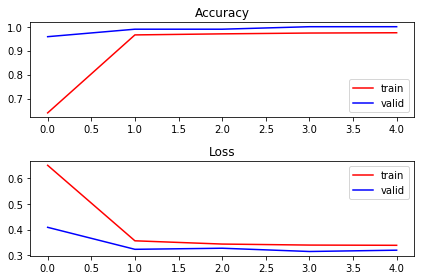

In [10]:
losses = [x[0] for x in history]
val_losses = [x[1] for x in history]
accs = [x[2] for x in history]
val_accs = [x[3] for x in history]

plt.subplot(211)
plt.title("Accuracy")
plt.plot(accs, color="r", label="train")
plt.plot(val_accs, color="b", label="valid")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(losses, color="r", label="train")
plt.plot(val_losses, color="b", label="valid")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Test/Evaluate Network

In [12]:
saved_model = CNNLSTM(FRAME_SIZE, 1, 2, 2, 1, 1, 2, SEQUENCE_LENGTH, 50, 1, 2)
saved_model.load_state_dict(torch.load(MODEL_FILE.format(5)))
if torch.cuda.is_available():
    saved_model.cuda()

In [13]:
ylabels, ypreds = [], []
num_test_batches = Xtest.shape[0] // BATCH_SIZE
for bid in range(num_test_batches):
    Xbatch_data = Xtest[bid * BATCH_SIZE : (bid + 1) * BATCH_SIZE]
    ybatch_data = ytest[bid * BATCH_SIZE : (bid + 1) * BATCH_SIZE]
    Xbatch = Variable(torch.from_numpy(Xbatch_data).float())
    ybatch = Variable(torch.from_numpy(ybatch_data).long())
    if torch.cuda.is_available():
        Xbatch = Xbatch.cuda()
        ybatch = ybatch.cuda()

    Ybatch_ = saved_model(Xbatch)
    _, ybatch_ = Ybatch_.max(1)
    if torch.cuda.is_available():
        ylabels.extend(ybatch.cpu().data.numpy())
        ypreds.extend(ybatch_.cpu().data.numpy())
    else:
        ylabels.extend(ybatch.data.numpy())
        ypreds.extend(ybatch_.data.numpy())

print("Test accuracy: {:.3f}".format(accuracy_score(ylabels, ypreds)))
print("Confusion matrix")
print(confusion_matrix(ylabels, ypreds))

Test accuracy: 0.988
Confusion matrix
[[210   4]
 [  2 264]]


In [14]:
for i in range(NUM_EPOCHS):
    os.remove(MODEL_FILE.format(i + 1))